In [2]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")

In [3]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import accuracy_score
from keras import backend
import glob
import random
import CNN_Module as cnn_module
import models
import glue_code

Using TensorFlow backend.


In [4]:
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(80,augment_train,augment_valid)
params_test['batch_size']=24
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [331]:
len(train_labels)

842

In [37]:
#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus

random.shuffle(train_labels)
random.shuffle(test_labels)

video_path = '/cropped_video80'
sample_gap = 10
im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

In [323]:
np.arange(0,3)

array([0, 1, 2])

In [334]:
model = models.get_luke_model(80)

accuracies_togther = []
num_models = 15
for statistics_repeat in np.arange(0,5):
    #prep cells for feeding into CNN
    control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/control/'))
    sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
    
    #label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
    control_cells_label = cnn_module.create_label_dict(control_cells,0)
    sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)
    
    train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
    train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)
    
    train_labels = train_ctrl+train_sus
    test_labels = test_ctrl+test_sus
    
    random.shuffle(train_labels)
    random.shuffle(test_labels)
    
    video_path = '/cropped_video80'
    sample_gap = 10
    im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
    random.shuffle(im_paths_train)
    
    
    result_predicting = []
    for repeat in np.arange(0,num_models): 
        random.shuffle(im_paths_train)
        ##fit model
        epochs=20
        stepsperepoch=100
        training_generator = DataGenerator.DataGenerator(im_paths_train, im_labels_train, **params_train)
        model.fit_generator(generator=training_generator,epochs = epochs,steps_per_epoch=stepsperepoch,verbose=0)
        #make predictions
        prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)
        preds = model.predict_generator(generator=prediction_generator,workers=1,steps = len(im_paths_test)//24, use_multiprocessing=False)
        
        filenames_preds = dict(zip(prediction_generator.filenames,preds))   
        result_predicting.append(filenames_preds)
        reset_weights(model)
        
        print(repeat)
        
    result_ensembling = []
    for key in list(result_predicting[0].keys()):
        image_preds = []
        correct_label = im_labels_test[key]
        for dictionary in result_predicting:     
            prediction = dictionary[key]
            image_preds.append(prediction)
        result_ensembling.append([correct_label,image_preds])
        
    #get result array which = [label, 1 model, 3 models, 5 models, 7 models, 9 models]
    result = []
    for image in result_ensembling:
        prediction_num_models = []
        for i in np.arange(1,num_models+1,2):
            predictions = image[1][:i]#2d probabilities from each model
            integer_predictions = list(np.argmax(np.array(predictions),axis=1))#integer predictions from each model
            final_prediction = max(set(integer_predictions), key=integer_predictions.count)#most common integer prediction
            prediction_num_models.append(final_prediction)#prediction for 1,3,5,7,9 models
        
        result.append(np.insert(prediction_num_models,0,image[0]))#label, prediction for 1,3,5,7,9 models
    result = np.array(result) 
    accuracies = [accuracy_score(result[:,0],result[:,i]) for i in np.arange(1,7)]
    print(accuracies)
    accuracies_togther.append(accuracies)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.7759683098591549, 0.8877640845070423, 0.9027288732394366, 0.8926056338028169, 0.8996478873239436, 0.897887323943662]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.8503521126760564, 0.8490316901408451, 0.8745598591549296, 0.8736795774647887, 0.8776408450704225, 0.8816021126760564]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.863556338028169, 0.8705985915492958, 0.883362676056338, 0.8842429577464789, 0.886443661971831, 0.8868838028169014]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.8235035211267606, 0.8402288732394366, 0.8648767605633803, 0.8855633802816901, 0.8824823943661971, 0.8868838028169014]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.7535211267605634, 0.809419014084507, 0.8336267605633803, 0.8419894366197183, 0.8499119718309859, 0.8485915492957746]


In [207]:
#get the correct label for each prediction
result_ensembling = []
for key in list(result_predicting[0].keys()):
    image_preds = []
    correct_label = im_labels_test[key]
    for dictionary in result_predicting:
        
        prediction = dictionary[key]
        image_preds.append(prediction)
    result_ensembling.append([correct_label,image_preds])

In [242]:
#get result array which = [label, 1 model, 3 models, 5 models, 7 models, 9 models]
num_models = 10
result = []
for image in result_ensembling:
    prediction_num_models = []
    for i in np.arange(1,num_models,2):
        predictions = image[1][:i]#2d probabilities from each model
        integer_predictions = list(np.argmax(np.array(predictions),axis=1))#integer predictions from each model
        final_prediction = max(set(integer_predictions), key=integer_predictions.count)#most common integer prediction
        prediction_num_models.append(final_prediction)#prediction for 1,3,5,7,9 models
        
    result.append(np.insert(prediction_num_models,0,image[0]))#label, prediction for 1,3,5,7,9 models
result = np.array(result)   

In [335]:
import pickle
pickle.dump(accuracies_togther,open('5_full_ensemble_experiments.p','wb'))

In [5]:
accuracies_togther=pickle.load(open('5_full_ensemble_experiments.p','rb'))

In [13]:
xs_scatter =[]
for i in range(5):
    i = np.arange(1,13,2)
    i = list(i)
    xs_scatter.extend(i)

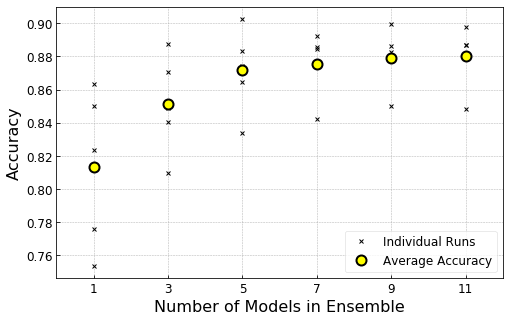

In [60]:
plt.style.use('bmh')
plt.rcParams.update({"figure.figsize" : (8, 5),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xticks([1,3,5,7,9,11])
num_models=15
plt.plot(xs_scatter,np.array(accuracies_togther).flatten(),color='black',marker='x',markersize=4,linewidth=0,label = 'Individual Runs')
plt.plot(np.arange(1,num_models-2,2), np.average(np.array(accuracies_togther),axis=0),color='yellow',marker='o',linewidth = 0, markersize=10,mew=2,mec='black',label='Average Accuracy')
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Number of Models in Ensemble',fontsize=16)
plt.legend(loc=4,frameon=True,fontsize=12)
plt.xlim(0,12)
plt.savefig('/home/ubuntu/data/figures/Ensemble.png',dpi=300)

In [11]:
np.arange(1,num_models-2,2)

array([ 1,  3,  5,  7,  9, 11])

In [185]:
predictions

[array([1.0000000e+00, 1.8792168e-12], dtype=float32),
 array([9.9999988e-01, 1.3411567e-07], dtype=float32),
 array([9.9999762e-01, 2.3564676e-06], dtype=float32),
 array([9.9999976e-01, 2.6209159e-07], dtype=float32),
 array([1.000000e+00, 1.102331e-08], dtype=float32),
 array([1.0000000e+00, 1.6388351e-12], dtype=float32),
 array([0.98137474, 0.0186252 ], dtype=float32),
 array([1.000000e+00, 6.366477e-10], dtype=float32),
 array([1.0000000e+00, 3.1398755e-13], dtype=float32),
 array([0.9988938 , 0.00110626], dtype=float32)]

In [44]:
len(train_labels)

842